# Homework 2

The purpose of the second homework is to become familiar with Local Interpretable Model-agnostic Explanations (LIME).

You may use any vision model from https://huggingface.co/.
You can choose any classification problem.
There are many example models on huggingface, for example, for food classification.
You can also try to reproduce the classification example for wolf/husky classes shown in the paper on LIME.

Try to implement the lime algorithm yourself, for this there is a full set of points. If you have problems, you can use some existing implementation, for this there will be a part of points.

Submit the homework to this directory.

## Deadline

2023-11-08 EOD

## Task

For the selected two or three images and a vision model, prepare a knitr/jupyter notebook based on the following points.
Submit your results on GitHub to the directory `Homeworks/HW2`.

1. Calculate the predictions for selected observations
2. Then, calculate 20-50 regions (may be less, depending on the resolution of the image) for a given image. You may divide the image in a grid of rectangles or use some smarter segmentation algorithms.
3. Generate N (100-1000 depending) subimages with randomly selected parts of an image. Calculate predictions for these parts.
4. Calculate LIME explanations
5. Comment on the results obtained in (4)


##Solution

In [1]:
#@title Imports
import numpy as np
import cv2
!pip install lime
from lime import lime_image
import matplotlib.pyplot as plt
from transformers import MobileViTFeatureExtractor, MobileViTForImageClassification
from PIL import Image
from skimage.segmentation import slic
from skimage.util import img_as_float
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_distances
from skimage.segmentation import mark_boundaries
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch
!pip install datasets
from datasets import load_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


Resolving data files:   0%|          | 0/39 [00:00<?, ?it/s]

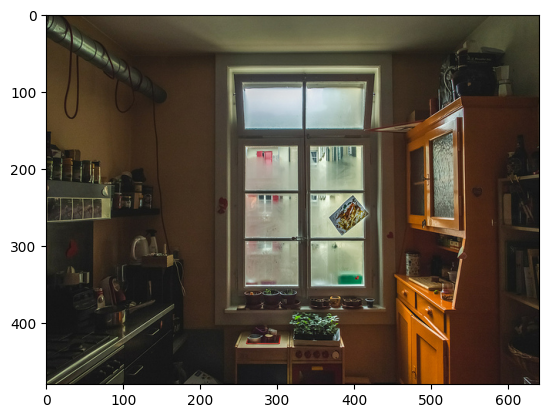

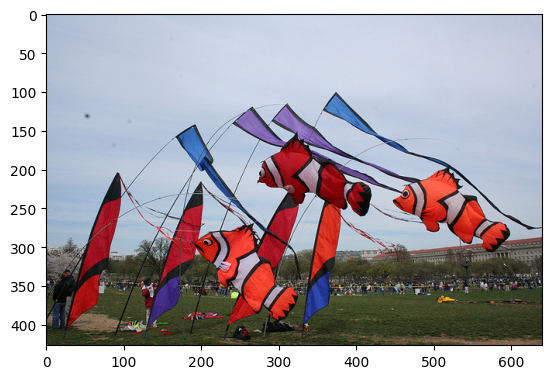

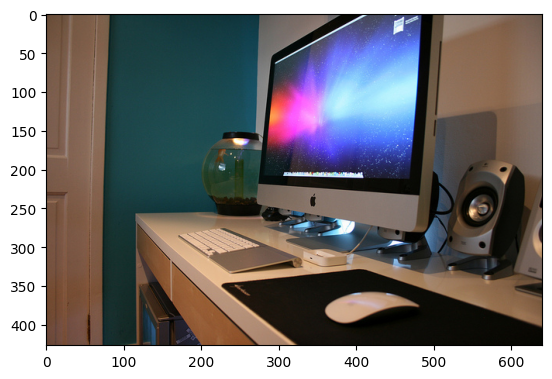

In [2]:
#@title Prepare the Model, Data - COCO2017 Validation and Parameters
model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")
feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/mobilevit-small")

model.eval()

dataset = load_dataset("rafaelpadilla/coco2017", split="val")
df = dataset.to_pandas()

del dataset

i1, i2, i3 = np.random.choice(range(0, len(df)), 3, replace=False)

img1 = cv2.imdecode(np.frombuffer(df['image'].iloc[i1]['bytes'], np.uint8), -1)
img2 = cv2.imdecode(np.frombuffer(df['image'].iloc[i2]['bytes'], np.uint8), -1)
img3 = cv2.imdecode(np.frombuffer(df['image'].iloc[i3]['bytes'], np.uint8), -1)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

num_samples = 100
top_labels = 5
n_segments = 20
n_top_segments = 5

In [3]:
#@title Functions
def preprocess_image(image, feature_extractor):
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values']

def predict(image_batch, model, feature_extractor):
    image_batch = torch.cat([preprocess_image(img, feature_extractor) for img in image_batch], dim=0)
    with torch.no_grad():
        outputs = model(image_batch)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probs

def segment_image(image, n_segments=20):
    image_np = np.array(image)
    segments = slic(image_np,
                    n_segments=n_segments,
                    compactness=10,
                    start_label=1)
    return segments

def generate_perturbations(image, segments, num_perturbations=1000, hide_color=(0, 0, 0)):
    n_segments = segments.max() + 1
    perturbations = []
    perturbed_images = []

    for _ in range(num_perturbations):
        mask = np.random.randint(0, 2, n_segments)
        perturbed_image = np.array(image).copy()
        for i in range(n_segments):
            if mask[i] == 0:
                perturbed_image[segments == i] = hide_color
        perturbations.append(mask)
        perturbed_images.append(Image.fromarray(perturbed_image))

    return np.array(perturbations), perturbed_images

def lime_explanation_custom(image, model_predict_fn, model_config, num_samples=1000, n_top_segments=5, n_segments=20):
    segments = segment_image(image, n_segments=n_segments)

    original_prediction = model_predict_fn([image])[0]
    predicted_class = np.argmax(original_prediction)
    print(f"Predicted class: {predicted_class}")
    print(f"Class name: {model_config.id2label[predicted_class]}")

    perturbations, perturbed_images = generate_perturbations(image, segments, num_samples)
    predictions = model_predict_fn(perturbed_images)[:, predicted_class]

    # Fit a linear model to predict classifier's response using the perturbation mask
    model = Ridge(alpha=1.0)
    model.fit(perturbations, predictions)

    # Get importance weights for each segment
    importance = model.coef_
def preprocess_image(image, feature_extractor):
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs['pixel_values']

def predict(image_batch, model, feature_extractor):
    image_batch = torch.cat([preprocess_image(img, feature_extractor) for img in image_batch], dim=0)
    with torch.no_grad():
        outputs = model(image_batch)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
    return probs

def segment_image(image, n_segments=20):
    image_np = np.array(image)
    segments = slic(image_np,
                    n_segments=n_segments,
                    compactness=10,
                    start_label=1)
    return segments

def generate_perturbations(image, segments, num_perturbations=1000, hide_color=(0, 0, 0)):
    n_segments = segments.max() + 1
    perturbations = []
    perturbed_images = []

    for _ in range(num_perturbations):
        mask = np.random.randint(0, 2, n_segments)
        perturbed_image = np.array(image).copy()
        for i in range(n_segments):
            if mask[i] == 0:
                perturbed_image[segments == i] = hide_color
        perturbations.append(mask)
        perturbed_images.append(Image.fromarray(perturbed_image))

    return np.array(perturbations), perturbed_images

def lime_explanation_custom(image, model_predict_fn, model_config, num_samples=1000, n_top_segments=5, n_segments=20):
    segments = segment_image(image, n_segments=n_segments)

    original_prediction = model_predict_fn([image])[0]
    predicted_class = np.argmax(original_prediction)
    print(f"Predicted class: {predicted_class}")
    print(f"Class name: {model_config.id2label[predicted_class]}")

    perturbations, perturbed_images = generate_perturbations(image, segments, num_samples)
    predictions = model_predict_fn(perturbed_images)[:, predicted_class]

    # Fit a linear model to predict classifier's response using the perturbation mask
    model = Ridge(alpha=1.0)
    model.fit(perturbations, predictions)

    # Get importance weights for each segment
    importance = model.coef_

    top_segments = np.argsort(importance)[-n_top_segments:]

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    explanation_image = np.array(image).copy()

    top_segments_mask = np.zeros_like(segments, dtype=bool)
    for segment_id in top_segments:
        top_segments_mask |= (segments == segment_id)

    highlighted_image = mark_boundaries(
        explanation_image,
        top_segments_mask,
        color=(1, 1, 0),  # Yellow color
        mode='thick'
    )

    ax[0].imshow(highlighted_image)
    ax[0].set_title(f"Top {n_top_segments} Important Segments for class {predicted_class}")
    ax[0].axis("off")

    threshold = np.percentile(importance, 70)  # threshold for importance
    blacked_out_image = np.array(image).copy()
    for i in range(importance.shape[0]):
        if importance[i] < threshold:
            blacked_out_image[segments == i] = (0, 0, 0)

    ax[1].imshow(blacked_out_image)
    ax[1].set_title(f"Blacked Out Unimportant Segments for class {predicted_class}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

def lime_image_library(image, model, feature_extractor, top_labels, num_samples, n_segments):
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(
      np.array(image),
      classifier_fn=lambda x: predict(x, model, feature_extractor),
      top_labels=top_labels,  # Number of top labels to explain
      hide_color=0,  # Color used to hide segments
      num_samples=num_samples,  # Number of perturbed samples to generate
      segmentation_fn=lambda x: segment_image(x, n_segments)
  )

  predicted_class = np.argmax(predict([image], model, feature_extractor)[0])
  temp, mask = explanation.get_image_and_mask(
      label=predicted_class,
      positive_only=True,
      hide_rest=False,
      num_features=10,
      min_weight=0.05
  )

  plt.imshow(mark_boundaries(temp, mask))
  plt.title(f"LIME Explanation for class {predicted_class}")
  plt.axis("off")
  plt.show()

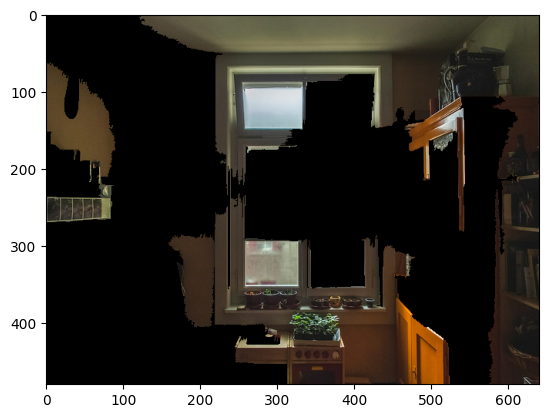

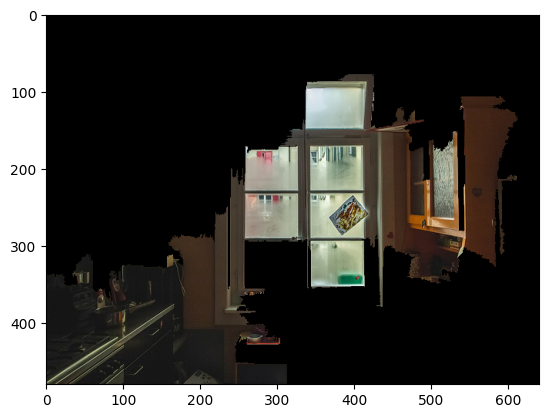

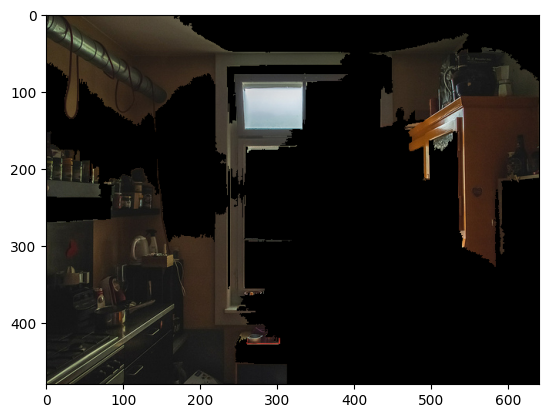

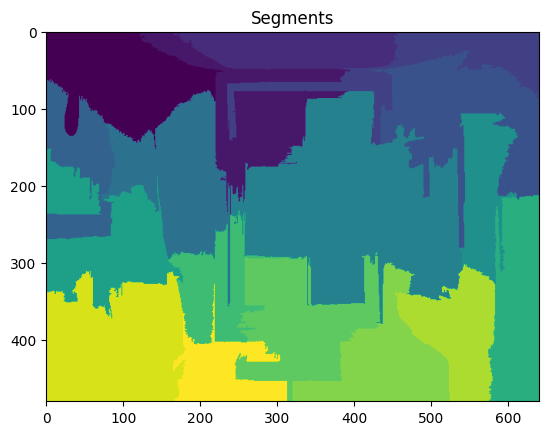

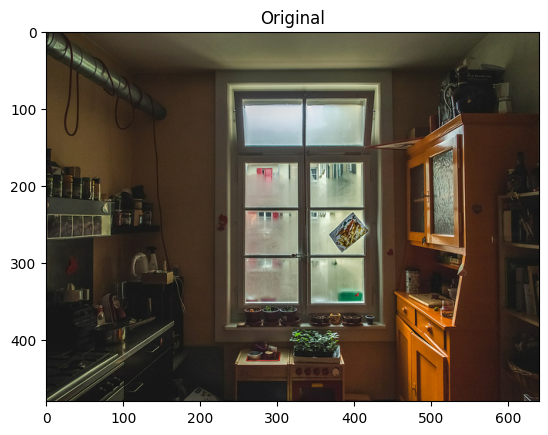

In [4]:
#@title Sample perturbations and segmentation
segments = segment_image(img1)
perturbations, pert_images = generate_perturbations(img1, segments)

for im in pert_images[:3]:
  plt.imshow(im)
  plt.show()

plt.title("Segments")
plt.imshow(np.expand_dims(segments, 2))
plt.show()

plt.title("Original")
plt.imshow(img1)
plt.show()

Predicted class: 424
Class name: barbershop


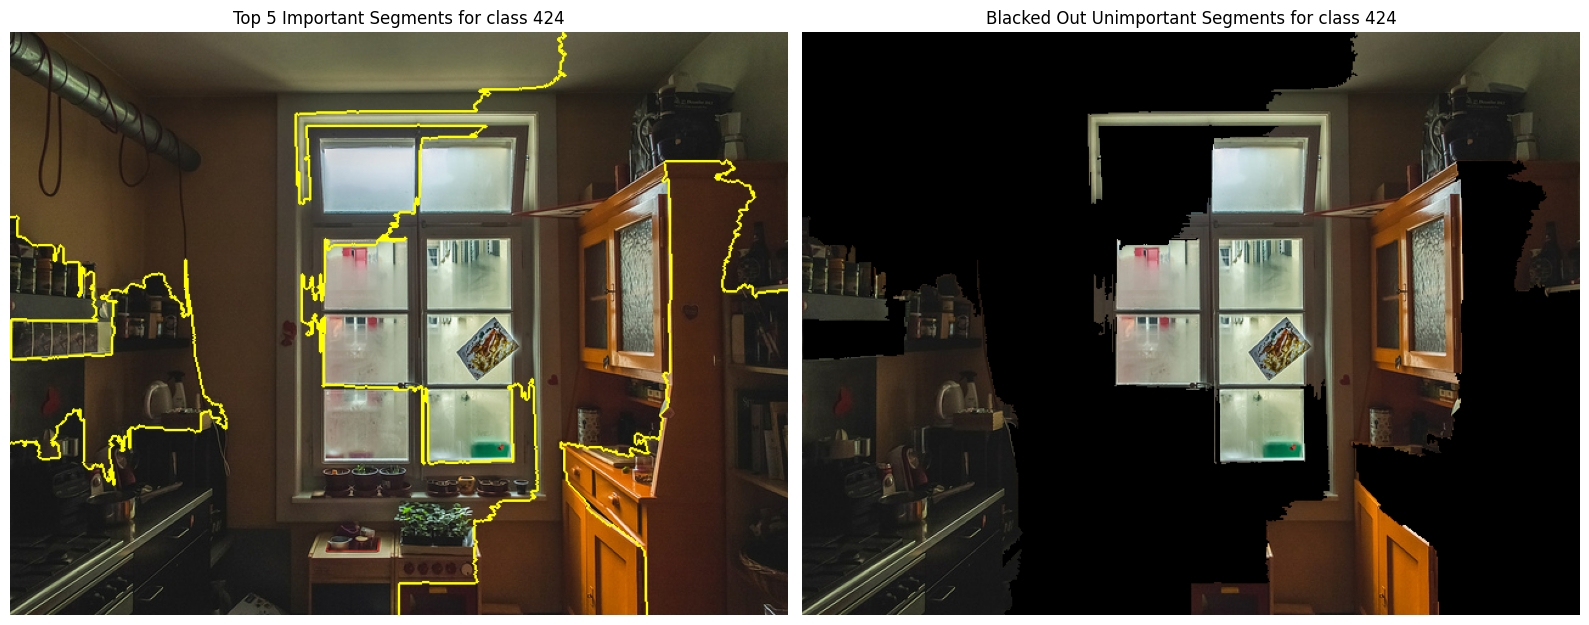

Predicted class: 701
Class name: parachute, chute


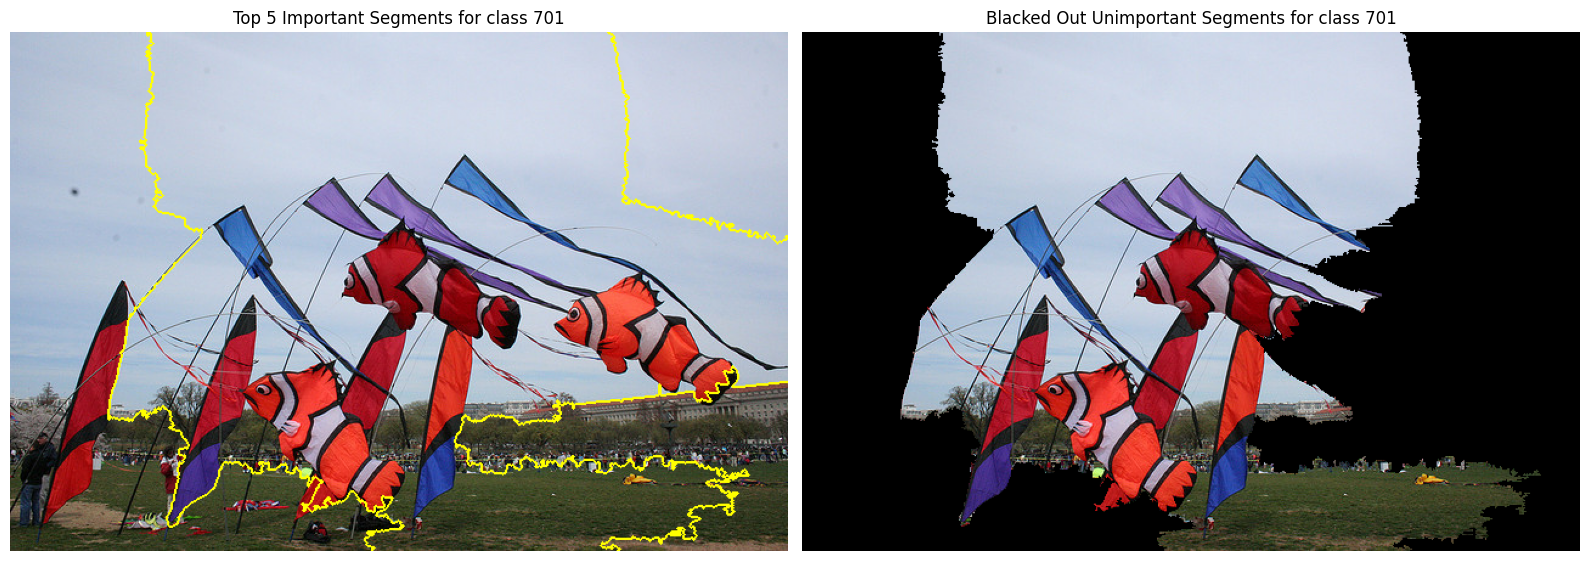

Predicted class: 527
Class name: desktop computer


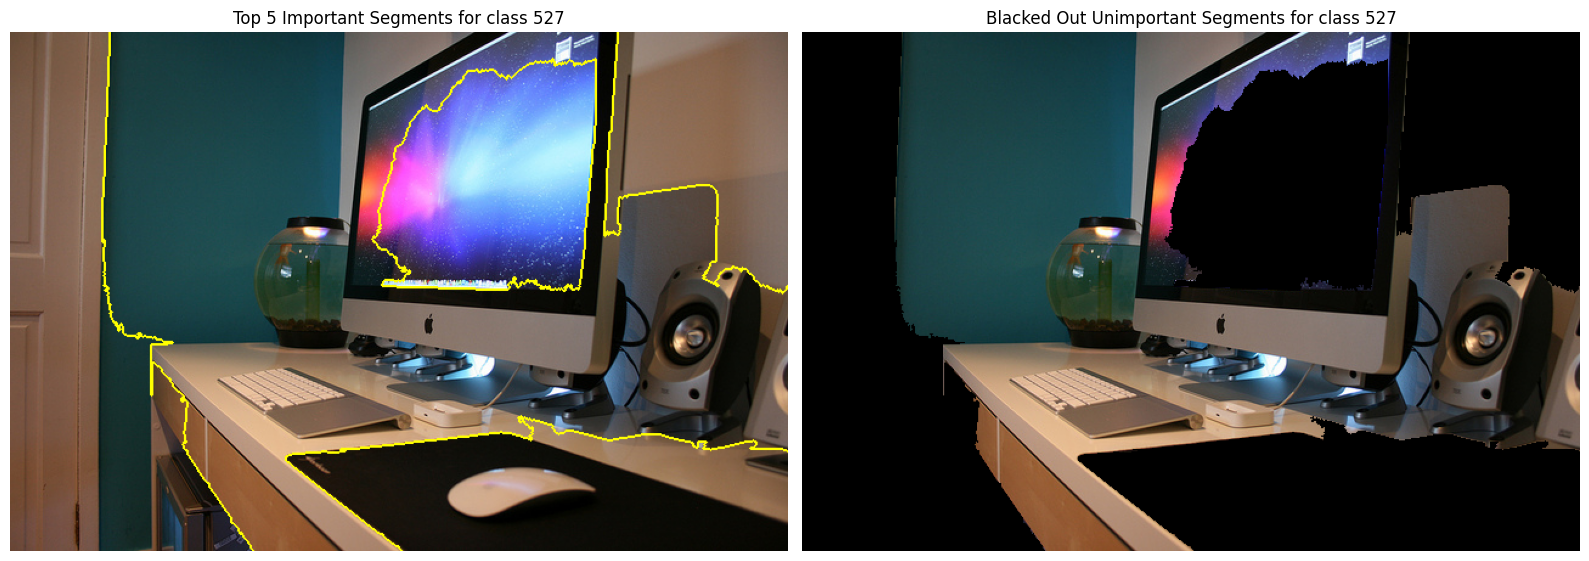

In [5]:
#@title Lime explanations - custom implementation
lime_explanation_custom(img1,
                 lambda x: predict(x, model, feature_extractor),
                 model.config,
                 num_samples=num_samples,
                 n_top_segments=n_top_segments,
                 n_segments=n_segments)

lime_explanation_custom(img2,
                 lambda x: predict(x, model, feature_extractor),
                 model.config,
                 num_samples=num_samples,
                 n_top_segments=n_top_segments,
                 n_segments=n_segments)

lime_explanation_custom(img3,
                 lambda x: predict(x, model, feature_extractor),
                 model.config,
                 num_samples=num_samples,
                 n_top_segments=n_top_segments,
                 n_segments=n_segments)

  0%|          | 0/100 [00:00<?, ?it/s]

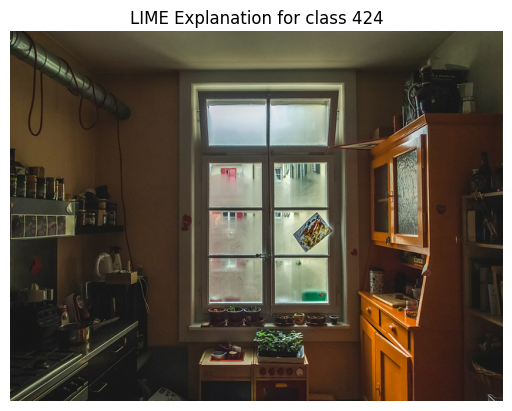

  0%|          | 0/100 [00:00<?, ?it/s]

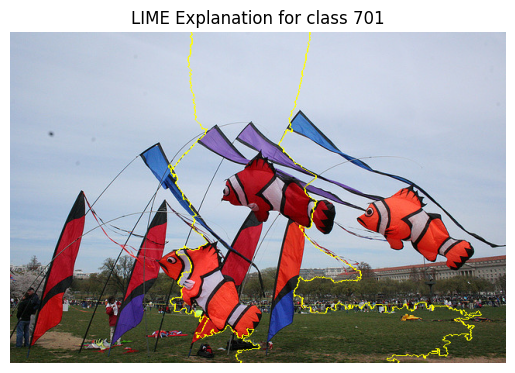

  0%|          | 0/100 [00:00<?, ?it/s]

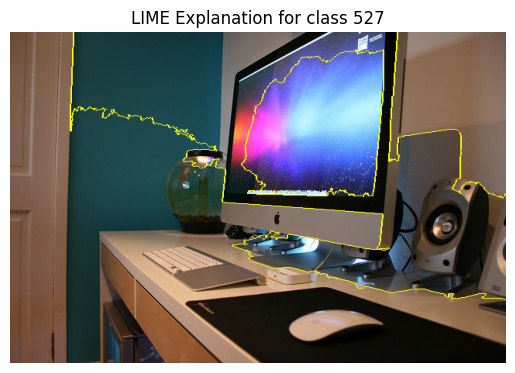

In [6]:
#@title Lime Explanations - basic implementation from an existing library
lime_image_library(img1,
                   model,
                   feature_extractor,
                   top_labels,
                   num_samples,
                   n_segments)

lime_image_library(img2,
                   model,
                   feature_extractor,
                   top_labels,
                   num_samples,
                   n_segments)

lime_image_library(img3,
                   model,
                   feature_extractor,
                   top_labels,
                   num_samples,
                   n_segments)

##Summary

I've decided to implement the LIME algorithm myself and compare the results with an implementation from a popular library.

I am testing the method by preparing explanations for three randomly chosen images from the COCO 2017 validation dataset. I'm explaining mobilevit-small model from Apple. As You can see on the images above, both methods produce different explanations, even though the segmentation algorithm is the same. Unfortunately, My method runs slower than the official implementation.